## import

In [66]:
## on hubel, set python interpreter path: C:\Users\ll357\AppData\Local\anaconda3\python.exe

import os
import warnings
from tqdm import tqdm
import pickle
from IPython.display import clear_output

import numpy as np
from numpy import dot
from numpy.linalg import norm
import scipy.io as sio
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none' # export svg compatible with coreldraw
%matplotlib inline

from statsmodels.stats.proportion import proportion_confint
from sklearn.svm import LinearSVC
    # Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, 
    # so it scale better to large numbers of samples.
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut

from sklearn.decomposition import PCA
import umap

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## func

In [8]:
def calc_SNR(df_tidy):
    ## SNR of R1, aka (R2 without adapter, isi=6k)
    tmp = df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)].groupby(['cell_id', 'stim2_id']).dfof
    SNR_R1 = (tmp.mean() / tmp.std()).reset_index()
    
    ## modified SNR of R1: for cell, (max-min resp) / (median std over ori)
    dfof_range_ori = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)]
                    .groupby(['cell_id', 'stim2_id'])
                    .dfof.mean().reset_index() # mean dfof for each cell and each stim2_id
                    .groupby('cell_id').dfof.apply(lambda x: x.max() - x.min()) # (max - min) resp for each cell over all stim2_id
                    .reset_index()
                    .rename(columns={'dfof': 'dfof_range'})
                    )
    dfof_std_ori  = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)]
                    .groupby(['cell_id', 'stim2_id'])
                    .dfof.std().reset_index()
                    .groupby('cell_id').dfof.median() # median std over stim2_id
                    .reset_index()
                    .rename(columns={'dfof': 'dfof_std_med'})
                    )
    SNR_R1_mod = dfof_range_ori.dfof_range / dfof_std_ori.dfof_std_med
    dfof_SNR_R1_mod = dfof_range_ori.copy()
    dfof_SNR_R1_mod['SNR_R1_mod'] = SNR_R1_mod

    ## SNR of R2, aka (R2 with adapter, isi=250)
    tmp = df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 250)].groupby(['cell_id', 'stim2_id']).dfof
    SNR_R2 = (tmp.mean() / tmp.std()).reset_index()

    ## merge to df
    df_SNR = SNR_R1.merge(SNR_R2, on=['cell_id', 'stim2_id'], suffixes=('_R1', '_R2'))
    df_SNR.columns = ['cell_id', 'stim2_id', 'SNR_R1', 'SNR_R2'] # rename columns
    df_SNR = df_SNR.merge(dfof_SNR_R1_mod, on=['cell_id'])
    df_SNR = df_SNR.sort_values(by='SNR_R1_mod', ascending=False)
    return df_SNR


def get_df_svc(df_tidy, iarea='V1', idatesess=0, ncell_keep=15, filter_cell='vis_pval'):
    df_svc = df_tidy[['dfof', 
                    'cell_id', 'resp_id', 'isi', 'stim2_id', 'stim2_dist_id', 'trial_id',
                    'filter_cell_vis', 'filter_cell_stim', 'filter_cell_vis_pval', 'filter_cell_well_fit', 
                    'area', 'mouse', 'date', 'sess'
                    ]]

    df_svc['stim2_dist'] = df_svc.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                            # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
    df_svc['date_sess'] = df_svc.date + '_' + df_svc.sess
    
    df_svc = df_svc[
                    # (df_svc.isi != 750)
                    # & 
                    (df_svc.filter_cell_vis == True)
                    & (df_svc.resp_id == 'R2') # only decode R2, with or without adapter (differentiate by isi)
                    & (df_svc.area == iarea)
                    ]
    date_sess_now = df_svc.date_sess.unique()[idatesess] # sess id in a specific area, with filter_cell_vis=True
    df_svc = df_svc[df_svc.date_sess == date_sess_now]

    if df_svc.cell_id.nunique() > ncell_keep:
        
        if filter_cell == 'vis_pval':
            vis_pval_thresh = (df_svc.groupby('cell_id').first()
                            .filter_cell_vis_pval.sort_values() # ascending, smaller pval better
                            [ncell_keep]) # nsample (nrep trial) too small, need to reduce nfeature (ncell)
            df_svc = df_svc[df_svc.filter_cell_vis_pval < vis_pval_thresh]

        if filter_cell == 'well_fit':
            df_svc = df_svc[df_svc.filter_cell_well_fit == True]
        
        if filter_cell == 'SNR':
            df_SNR = calc_SNR(df_svc)
            model_cell_id = (df_SNR.groupby('cell_id')
                            .SNR_R1.max().reset_index()
                            .sort_values('SNR_R1', ascending=False)
                            .head(ncell_keep).cell_id.values
                            )
            df_svc = df_svc[df_svc.cell_id.isin(model_cell_id)]
            assert set(df_svc.cell_id.unique()) == set(sorted(model_cell_id))
            
        if filter_cell == 'SNR_R1_mod':
            df_SNR = calc_SNR(df_svc)
            model_cell_id = (df_SNR.groupby('cell_id')
                            .SNR_R1_mod.first().reset_index()
                            .sort_values('SNR_R1_mod', ascending=False)
                            .head(ncell_keep).cell_id.values
                            )
            df_svc = df_svc[df_svc.cell_id.isin(model_cell_id)]
            assert set(df_svc.cell_id.unique()) == set(sorted(model_cell_id))
            
        # if filter_cell == 'gOSI':
        #     df_gOSI_sess = df_gOSI[df_gOSI.date_sess == date_sess_now]
        #     model_cell_id = (df_gOSI_sess.sort_values('gOSI_noad', ascending=False)
        #                      .head(ncell_keep).cell_id.values
        #                      )
        #     df_svc = df_svc[df_svc.cell_id.isin(model_cell_id)]
        
    return df_svc


def df_to_train_test(df, ref_ori_id=0, train_only=True, multiclass=False):
    # input: filtered df_svc
    # output: X_train, X_test, y_train, y_test (of the filter condition)
        # X shape = ntrial x ncell, y shape = ntrial
    # train_only: only get train data from df, no test. 
        # use only train-val split in cross val, not train-val-test split
    # double checked 2023-10-17
    
    label_arr = df.groupby('trial_id').stim2_id.first().values
    if multiclass == False:
        label_arr = (label_arr == ref_ori_id) # True = ref ori, False = other ori
    # else: multiclass label keeps stim2_id (0-7)
    
    feature_mat = (df
                   .pivot_table(index=['trial_id'], # row = observation
                                columns='cell_id', # col = feature
                                values='dfof')
                   .to_numpy())
    
    assert feature_mat.shape[0] == label_arr.shape[0]
    
    if train_only == False:
        X_train, X_test, y_train, y_test = train_test_split(
            feature_mat, label_arr, 
            test_size=0.2,
            # test_size=int(1), # 1 trial for test
            random_state=0, shuffle=True) 
    
    if train_only == True:
        X_train, y_train = feature_mat, label_arr
        X_test, y_test = None, None
    
    return X_train, y_train, X_test, y_test

# write df_tidy (don't rerun unless needed)
modified to apply to grat 2ori 2isi, multisess

In [27]:
dir_repo = r'C:\Users\ll357\Documents\inter/'.replace('\\', '/')
os.chdir(dir_repo)
from src import adp

dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_xls = os.path.join(dir_data, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_xls)

meta = data_info[(data_info.paradigm == 'grating_2ori_multisess') 
                #  & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True)) # ensure segmentation
                 ].reset_index(drop=True)
nset = meta.shape[0]
meta

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,time,AWS,note
0,1380,240206,V1,NaN,002,1.0,NaN,grating_2ori_multisess,6s,951.0,NaN,"grating_2ori_multisess: ori = 22 or 0, isi = 6..."
1,1380,240206,V1,NaN,003,1.0,NaN,grating_2ori_multisess,6s,1139.0,NaN,marked timestamp because lindsey use pdf not x...


In [30]:
# iset = 1 # multisess, only 1 dataset

# ## load data
# mouse = meta.loc[iset, 'mouse'].astype(str)
# imouse = 'i' + mouse
# date = meta.loc[iset, 'date'].astype(str)
# area = meta.loc[iset, 'area']
# # sess = meta.loc[iset, 'num']
# # print(mouse, date, area, sess)
# dir_identifier = f'{area}_{imouse}_{date}_cellpose' # multisess. TODO: fix hard code
# # dir_identifier = f'{area}_{imouse}_{date}_{sess}_cellpose'# single sess

# mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
# for dirname in os.listdir(mat_inter):
#     if dir_identifier in dirname:
#         dir_data = mat_inter + dirname
#         break
# print(dir_data)

# stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab. only differentiating isi in resp_tg by indexing into trial. match isi_nframe
# ## NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial


# ## construct dfof
# R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
# R2_dfof = resp_tg.flatten()
# dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id


# ## construct cell, trial, resp id
# ncell = resp_ad.shape[0]
# ntrial = resp_ad.shape[1]
# cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
# cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

# trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
# trial_id = np.hstack((trial_id, trial_id))

# len_df = ncell * ntrial * 2 # 2 for (R1, R2)
# resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg


# ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
# trial_stim_orien = stim_id['stim_ori'][0]
# # trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
# trial_stim_orien_dict = {} ## map stim2 orientation to int. convert from grat ori in deg to 0-based indexing (ensured)
# for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
#     trial_stim_orien_dict[item] = i
# trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]
# print(trial_stim_orien_dict)

# trial_isi_nframe = stim_id['isi_nframe'][0]
# # trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
# trial_adapter_contrast = stim_id['adapter_contrast'][0]
# # trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

# trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
# trial_isi_nframe = trial_isi_nframe[:ntrial]
# trial_adapter_contrast = trial_adapter_contrast[:ntrial]


# ## make stim info col: same as trial_id - tile then hstack
# stim_id_col = np.tile(trial_stim_orien_int, ncell)
# isi_col = np.tile(trial_isi_nframe, ncell)
# ad_con_col = np.tile(trial_adapter_contrast, ncell)

# stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
# isi_col = np.hstack((isi_col, isi_col))
# ad_con_col = np.hstack((ad_con_col, ad_con_col))


# df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
#                         'isi': isi_col, 'stim1_contrast': ad_con_col, 
#                         'stim2_id': stim_id_col,})
# df_tidy['area'] = area
# df_tidy['stim1_id'] = 0 # adapter (stim1) is always 0 deg / vertical gratings
# df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
# df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

# df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms. 250 ms is about 8 frames, 750 ms is about 22-23 frames
# df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)


# ## vis cell filter, well_fit filter, & img driven cell-stim filter
# df_tidy['filter_cell_vis'] = np.nan
# df_tidy['filter_cell_vis_pval'] = np.nan # allow continuous filtering on how significant the cell gets visually driven
# # df_tidy['filter_cell_well_fit'] = np.nan
# df_tidy['filter_cell_stim'] = np.nan

# with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni.pickle'), 'rb') as f:
#     filter_file = pickle.load(f)
# filter_cell_stim = filter_file['img_driven']
# filter_cell_vis = filter_file['vis_driven']
# filter_cell_vis_pval = np.min(filter_file['p_ttest'], axis=1) # min pval across all stim
    
# # well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
# # well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']])

# for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
#     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell]
#     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis_pval'] = filter_cell_vis_pval[icell]
#     # df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
#     for istim in np.arange(filter_cell_stim.shape[1]):
#         df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]

# ## save df_tidy as csv
# df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_continuous_vis_pval.csv'), index=False)

//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/mat_inter/V1_i1380_240206_cellpose
ncell: 126, nstim: 2, ntrial: 1556
{0.0: 0, 157.5: 1}


# load df_tidy

In [33]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_xls = os.path.join(dir_data, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_xls)
meta = data_info[(data_info.paradigm == 'grating_2ori_multisess') 
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))].reset_index(drop=True)
nset = meta.shape[0]
meta

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,time,AWS,note
0,1380,240206,V1,NaN,002,1.0,NaN,grating_2ori_multisess,6s,951.0,NaN,"grating_2ori_multisess: ori = 22 or 0, isi = 6..."
1,1380,240206,V1,NaN,003,1.0,NaN,grating_2ori_multisess,6s,1139.0,NaN,marked timestamp because lindsey use pdf not x...


In [36]:
nset = len(meta)
df_tidy = pd.DataFrame()

# for iset in tqdm(range(nset)):
    # print(f'iset={iset}, nset={nset}')

iset = 1 # multisess, only 1 dataset
mouse = meta.loc[iset, 'mouse'].astype(str)
imouse = 'i' + mouse
date = meta.loc[iset, 'date'].astype(str)
area = meta.loc[iset, 'area']
sess = meta.loc[iset, 'num']
# dir_identifier = f'{area}_{imouse}_{date}_{sess}'
dir_identifier = f'{area}_{imouse}_{date}'

dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
csv_filename = 'df_tidy_continuous_vis_pval.csv'
try:
    df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
except:
    dir_identifier = dir_identifier + '_cellpose'
    df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

df_tidy_now['mouse'] = mouse
df_tidy_now['date'] = date
df_tidy_now['sess'] = sess
df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                            + df_tidy_now.sess.astype(str) + '_' 
                            + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    
# clear_output()

In [41]:
## for now, well-fit = NaN. TODO: add well max col
df_tidy['filter_cell_well_fit'] = np.nan

In [39]:
## pair up stim2_id who have the same stim2_dist from adapter (0 deg)
## also works for pairing up those with same distance from ref=90 deg
stim2_dict = {0:0, 1:1, 2:2, 3:3, 4:4, 5:3, 6:2, 7:1}
df_tidy['stim2_dist_id'] = df_tidy.stim2_id.apply(lambda x: stim2_dict[x])
df_tidy[['stim2_id', 'stim2_dist_id']].drop_duplicates().sort_values(by='stim2_id')

,stim2_id,stim2_dist_id
2,0,0
0,1,1


## feature engineering (depre)
use PCA to reduce dimension

In [189]:
ncell_keep = 999
iarea = 'V1'
idatesess = 1 # Li, sess=9: not enough cells

filter_cell = 'vis_pval'
# filter_cell = 'SNR'
# filter_cell = 'SNR_R1_mod'
# filter_cell = 'well_fit'
# filter_cell = 'gOSI'

df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=idatesess, 
                    ncell_keep=ncell_keep, 
                    filter_cell=filter_cell)

df_svc.cell_id.nunique()

90

Explained variation per principal component: [0.14255453 0.06377805 0.0532789 ]
Explained variation per principal component: [0.10620993 0.05624148 0.05090528]


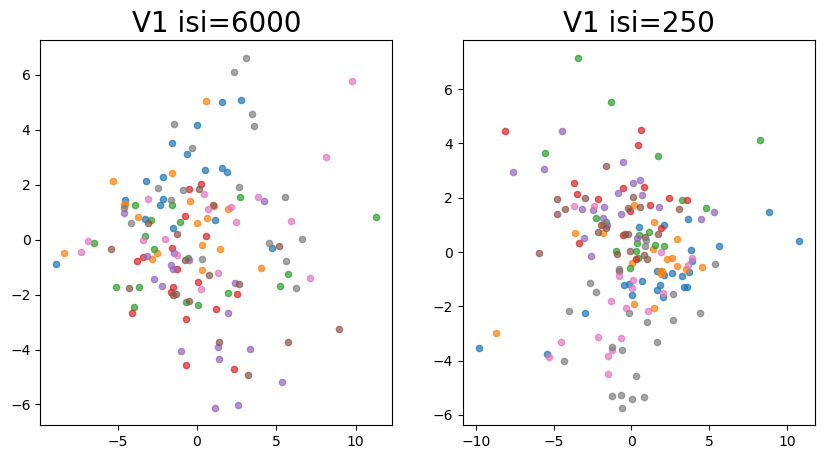

In [194]:
def prep_dimred(df_svc, isi_now=250):
    # input: df_svc, isi_now (250, 750, 6000)
    # output: features_normed (feature mat, standard scaled), stim2_id_arr (label across trials)
    df_pca = df_svc[df_svc.isi == isi_now].pivot_table(index=['trial_id'], columns='cell_id', values='dfof')
    stim2_id_arr = df_svc[df_svc.isi == isi_now].groupby('trial_id').stim2_id.first().values
    features = df_pca.values
    features_normed = StandardScaler().fit_transform(features) # normalize features before PCA
    return features_normed, stim2_id_arr



fig, ax = plt.subplots(1, 2, figsize=(10,5))

isi_now = 6000
features_normed, stim2_id_arr = prep_dimred(df_svc, isi_now=isi_now)
stim2_id_unique = np.unique(stim2_id_arr)

pca = PCA(n_components=3)
pc = pca.fit_transform(features_normed)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
df_pc = pd.DataFrame(data=pc, columns=['principal component 1', 
                                       'principal component 2', 
                                       'principal component 3'
                                    ])

for stim2_id in list(stim2_id_unique):
    trial_id_now = (stim2_id_arr == stim2_id)
    ax[0].scatter(df_pc.loc[trial_id_now, 'principal component 1'], 
                df_pc.loc[trial_id_now, 'principal component 2'], 
                s=20, alpha=0.7)
ax[0].set_title(f'{iarea} isi={isi_now}', fontsize=20);


    
isi_now = 250
features_normed, stim2_id_arr = prep_dimred(df_svc, isi_now=isi_now)
stim2_id_unique = np.unique(stim2_id_arr)

pca = PCA(n_components=3)
pc = pca.fit_transform(features_normed)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
df_pc = pd.DataFrame(data=pc, columns=['principal component 1', 
                                       'principal component 2', 
                                       'principal component 3'
                                    ])

for stim2_id in list(stim2_id_unique):
    trial_id_now = (stim2_id_arr == stim2_id)
    ax[1].scatter(df_pc.loc[trial_id_now, 'principal component 1'], 
                df_pc.loc[trial_id_now, 'principal component 2'], 
                s=20, alpha=0.7)
ax[1].set_title(f'{iarea} isi={isi_now}', fontsize=20);

# plt.legend(list(stim2_id_unique), prop={'size': 15}, bbox_to_anchor=(1.3, 1), loc='upper right');
# plt.xlabel('Principal Component 1', fontsize=20)
# plt.ylabel('Principal Component 2', fontsize=20)

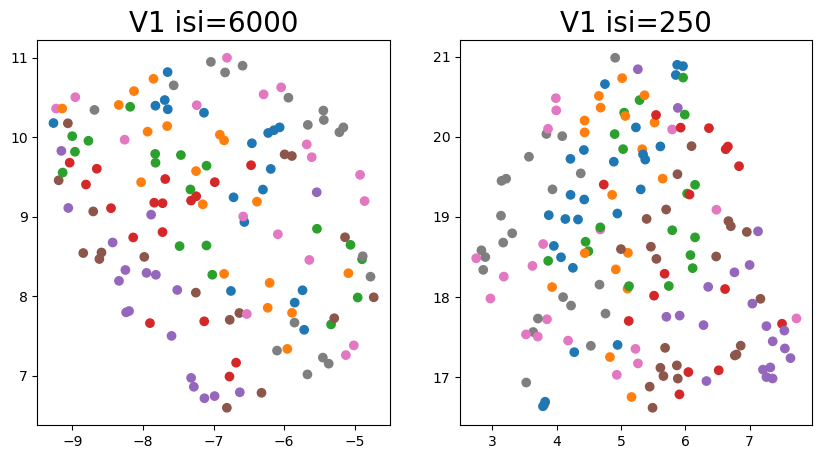

In [193]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

isi_now = 6000
features_normed, stim2_id_arr = prep_dimred(df_svc, isi_now=isi_now)
stim2_id_unique = np.unique(stim2_id_arr)

reducer = umap.UMAP()
embedding = reducer.fit_transform(features_normed)

ax[0].scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[stim2_id] for stim2_id in stim2_id_arr]
    )
# plt.gca().set_aspect('equal', 'datalim')
# plt.title(f'{iarea} isi={isi_now}', fontsize=20);
ax[0].set_title(f'{iarea} isi={isi_now}', fontsize=20);


    
isi_now = 250
features_normed, stim2_id_arr = prep_dimred(df_svc, isi_now=isi_now)
stim2_id_unique = np.unique(stim2_id_arr)

reducer = umap.UMAP()
embedding = reducer.fit_transform(features_normed)

ax[1].scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[stim2_id] for stim2_id in stim2_id_arr]
    )
ax[1].set_title(f'{iarea} isi={isi_now}', fontsize=20);

# plt.legend(list(stim2_id_unique), prop={'size': 15}, bbox_to_anchor=(1.3, 1), loc='upper right');
# plt.xlabel('Principal Component 1', fontsize=20)
# plt.ylabel('Principal Component 2', fontsize=20)

## feature selection
reduce ncell in model to prevent overfit

### filter cell gOSI (deprecated, no rerun)
calculate global orientation selectivity index (gOSI)  
formula taken from [Causal importance of orientation selectivity for generalization in image recognition](https://openreview.net/pdf?id=Bkx_Dj09tQ)

In [88]:
## df for tuning curve
df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis'
                    ]]
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    & (df_tuning.filter_cell_vis == True)
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    ]
                    
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when no adapter
    tuning_noad = (df_tuning.loc[(df_tuning.cell_id == icell) 
                                & (df_tuning.isi == 6000) # take R2 of no adapter trials
                                & (df_tuning.resp_id == 'R2'), :]
                   .groupby(['stim2_id'], sort=True) # sorted by key aka stim2_id
                   .dfof.agg(np.nanmean).values
                   )
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = (df_tuning
                                                                  .loc[(df_tuning.cell_id == icell), 'tuning_noad']
                                                                  .apply(lambda x: tuning_noad))
    
    ## tuning curve when there is adapter
    tuning_250 = (df_tuning.loc[(df_tuning.cell_id == icell) 
                                & (df_tuning.isi == 250) 
                                & (df_tuning.resp_id == 'R2'), :]
                  .groupby(['stim2_id'], sort=True)
                  .dfof.agg(np.nanmean).values
                  )
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = (df_tuning
                                                                 .loc[(df_tuning.cell_id == icell), 'tuning_250']
                                                                 .apply(lambda x: tuning_250))
    # break

df_tuning.tail(5)

100%|██████████| 1654/1654 [17:19<00:00,  1.59it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,tuning_noad,tuning_250
2379998,-0.025242,230309_002_79,R2,6000,3,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."
2379999,0.081034,230309_002_79,R2,6000,2,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."
2380001,0.108352,230309_002_79,R2,6000,0,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."
2380002,0.269638,230309_002_79,R2,250,4,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."
2380003,0.345687,230309_002_79,R2,6000,2,LI,True,"[0.027171706755775783, 0.09794865820137698, 0....","[-0.008992726503453645, 0.003331566276028924, ..."


In [89]:
for icell in tqdm(df_tuning.cell_id.unique()):
    df_cell = df_tuning[df_tuning.cell_id == icell]

    tuning_noad = df_cell.tuning_noad.values[0] - min(df_cell.tuning_noad.values[0]) # ensure all values are non negative
    tuning_250 = df_cell.tuning_250.values[0] - min(df_cell.tuning_250.values[0])

    theta_arr = np.linspace(0, 180-22.5, 8) # according to formula: unit deg, not rad
    sin_arr = np.sin(2 * theta_arr)
    cos_arr = np.cos(2 * theta_arr)

    gOSI_noad = np.sqrt((np.sum(tuning_noad * sin_arr))**2 + (np.sum(tuning_noad * cos_arr))**2) / np.sum(tuning_noad)
    gOSI_250 = np.sqrt((np.sum(tuning_250 * sin_arr))**2 + (np.sum(tuning_250 * cos_arr))**2) / np.sum(tuning_250)

    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_noad'] = gOSI_noad
    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_250'] = gOSI_250

df_tuning = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False)
df_tuning.groupby('cell_id', sort=False)['area', 'gOSI_noad', 'gOSI_250'].first()
# df_tuning.to_csv('df_tuning_grat8ori.csv', index=False)

100%|██████████| 1654/1654 [06:46<00:00,  4.07it/s]
C:\Users\lan\AppData\Local\Temp\6\ipykernel_44780\3524770447.py:18: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tuning.groupby('cell_id', sort=False)['area', 'gOSI_noad', 'gOSI_250'].first()


,area,gOSI_noad,gOSI_250
cell_id,,,
201209_002_88,V1,0.876308,0.682645
200728_003_33,V1,0.866154,0.729479
201015_004_15,V1,0.849340,0.496406
201015_004_12,V1,0.846736,0.789616
220228_002_16,LM,0.845744,0.809035
...,...,...,...
200728_003_72,V1,0.017878,0.317335
200804_003_68,LM,0.015051,0.136653
230302_003_136,LM,0.014923,0.443175


In [98]:
df_gOSI = df_tuning.groupby('cell_id', sort=False)[['gOSI_noad', 'gOSI_250']].first().reset_index()
df_gOSI['date_sess'] = df_gOSI['cell_id'].str.split('_').str[0] + '_' + df_gOSI['cell_id'].str.split('_').str[1]
df_gOSI

,cell_id,gOSI_noad,gOSI_250,date_sess
0,201209_002_88,0.876308,0.682645,201209_002
1,200728_003_33,0.866154,0.729479,200728_003
2,201015_004_15,0.849340,0.496406,201015_004
3,201015_004_12,0.846736,0.789616,201015_004
4,220228_002_16,0.845744,0.809035,220228_002
...,...,...,...,...
1649,200728_003_72,0.017878,0.317335,200728_003
1650,200804_003_68,0.015051,0.136653,200804_003
1651,230302_003_136,0.014923,0.443175,230302_003
1652,210120_003_34,0.011596,0.026943,210120_003


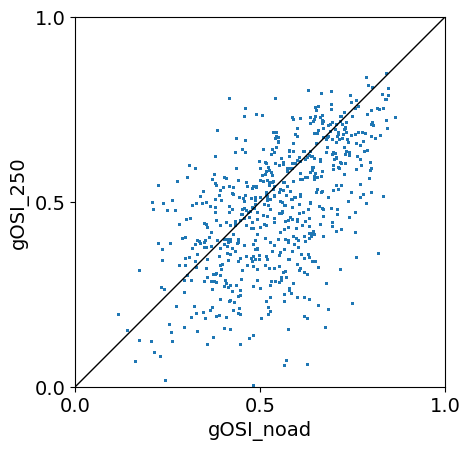

In [ ]:
tmp1 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_noad.values
tmp2 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_250.values

plt.scatter(tmp1, tmp2, alpha=.1, s=1);
plt.plot([0, 1], [0, 1], color='k', linestyle='-', linewidth=1); # draw diagonal line

plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.xticks([0, .5, 1]);
plt.yticks([0, .5, 1]);
plt.xlabel('gOSI_noad');
plt.ylabel('gOSI_250');
plt.gca().set_aspect('equal', adjustable='box'); # set axis square

## gOSI noad is usually higher. gOSI noad vs 250 is correlated

### filter cell SNR_mod, validate tuning
neuron in model should have diff tuning curves

In [44]:
ncell_keep = 15
iarea = 'V1'
idatesess = 0

# filter_cell = 'vis_pval'
# filter_cell = 'SNR'
filter_cell = 'SNR_R1_mod'
# filter_cell = 'well_fit'
# filter_cell = 'gOSI'

df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=idatesess, 
                    ncell_keep=ncell_keep, 
                    filter_cell=filter_cell)

df_svc.cell_id.nunique()

15

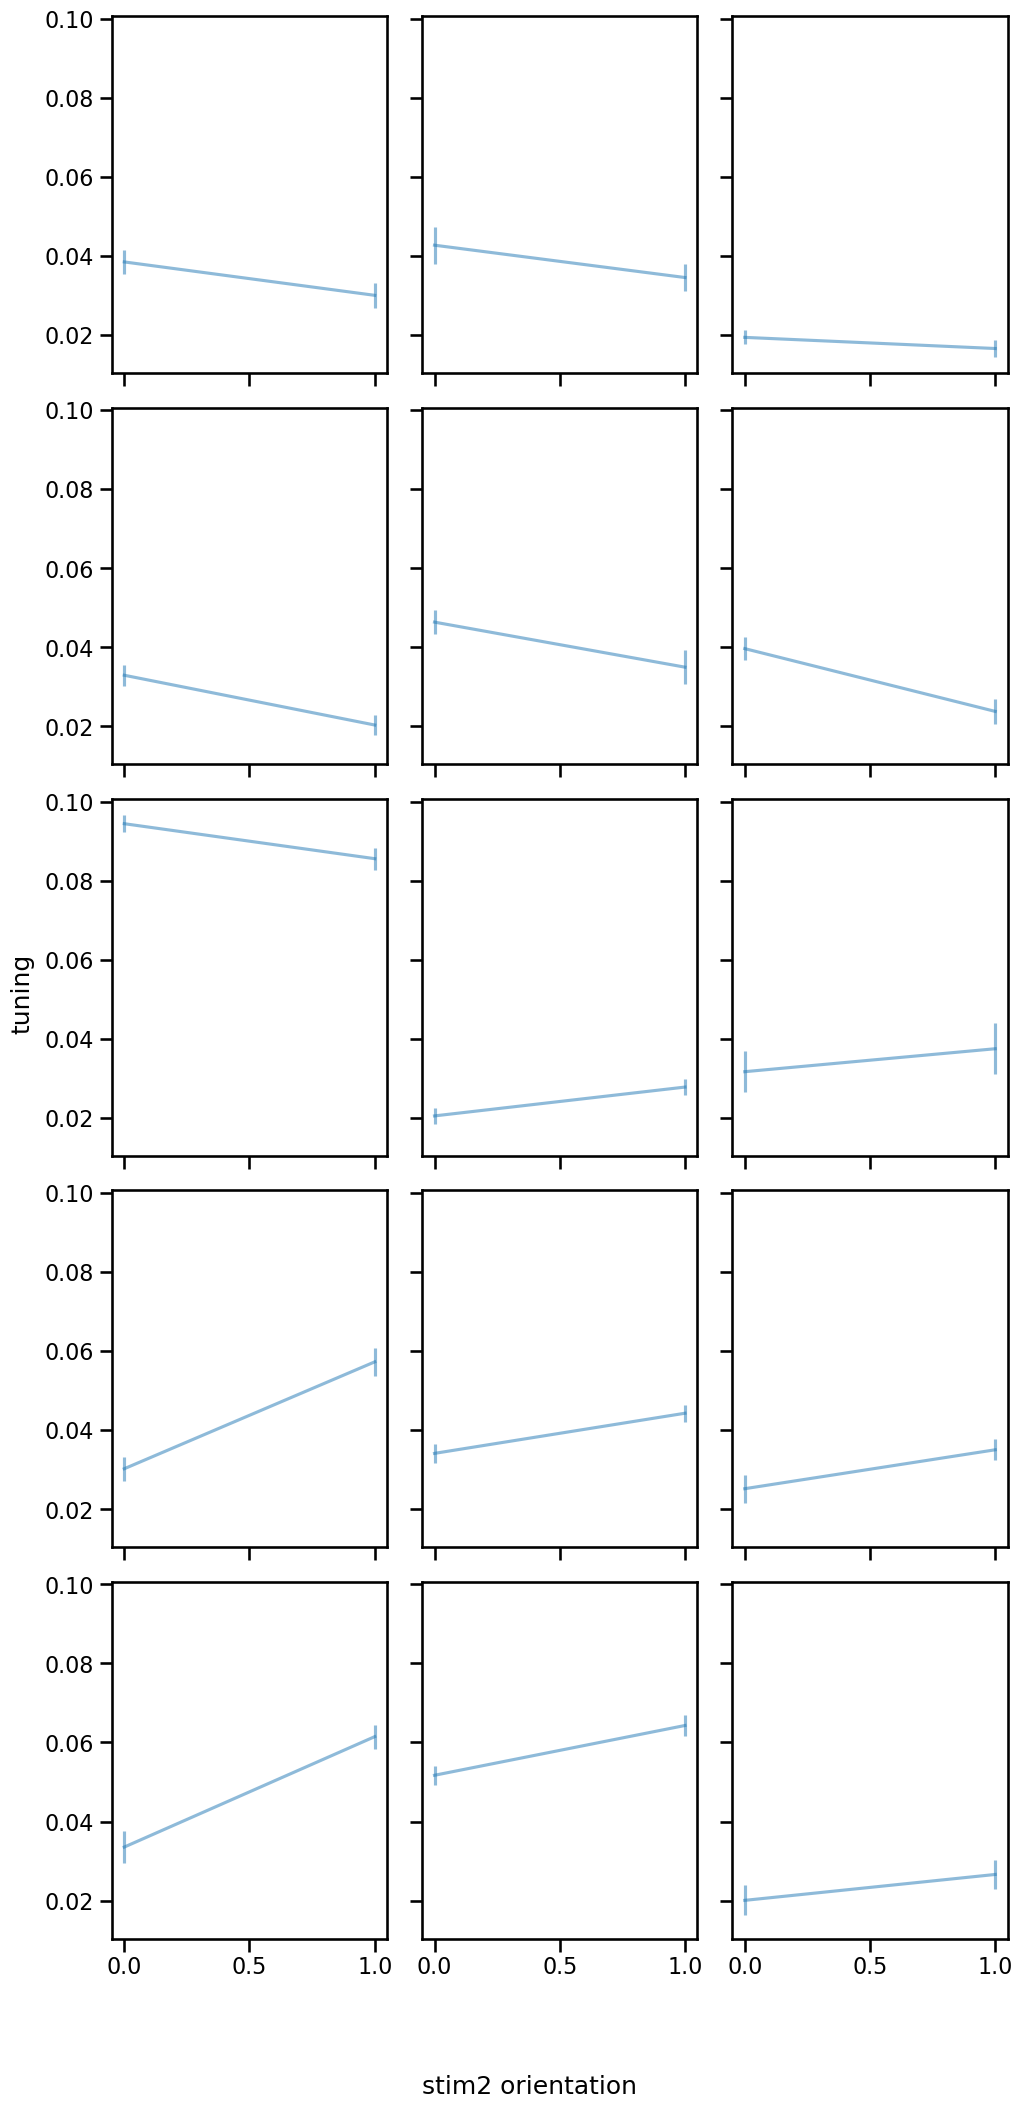

In [47]:
model_cell_resp = df_svc.groupby(['cell_id', 'stim2_id']).dfof.mean().reset_index()
model_cell_sem = df_svc.groupby(['cell_id', 'stim2_id']).dfof.sem().reset_index()

tuning_pop = []
tuning_pop_sem = []
for icell in sorted(df_svc.cell_id.unique()):
    tuning_cell = model_cell_resp[model_cell_resp.cell_id==icell].dfof.tolist()
    tuning_cell_sem = model_cell_sem[model_cell_sem.cell_id==icell].dfof.tolist()
    # tuning_cell = (tuning_cell - np.min(tuning_cell)) / (np.max(tuning_cell) - np.min(tuning_cell)) # min-max normalization
    tuning_pop.append(tuning_cell)
    tuning_pop_sem.append(tuning_cell_sem)

tuning_pop = np.array(tuning_pop) # ncell_keep x nori
tuning_pop_sem = np.array(tuning_pop_sem)
tuning_pop = tuning_pop[np.argsort(np.argmax(tuning_pop, axis=1)), :] # sort cells by tuning argmax
tuning_pop_sem = tuning_pop_sem[np.argsort(np.argmax(tuning_pop, axis=1)), :]

if ncell_keep > 15:
    nrow = 13
    ncol = df_svc.cell_id.nunique() // nrow
    fig, ax = plt.subplots(nrow, ncol, figsize=(10, 40), sharex=True, sharey=True)
else:
    nrow = 5
    ncol = df_svc.cell_id.nunique() // nrow
    fig, ax = plt.subplots(nrow, ncol, figsize=(10, 20), sharex=True, sharey=True)

nstim = df_tidy.stim2_id.nunique()
for isubplot in np.arange(nrow*ncol): # plot each cell in a subplot
    ax[isubplot//ncol, isubplot%ncol].errorbar(x=np.arange(nstim), 
                                               y=tuning_pop[isubplot], 
                                               yerr=tuning_pop_sem[isubplot], 
                                               alpha=0.5)
    # ax[isubplot//ncol, isubplot%ncol].text(0.5, 0.9, 
    #             f'cell ' + sorted(df_svc.cell_id.unique())[isubplot].split('_')[2],
    #             horizontalalignment='center',
    #             transform=ax[isubplot//ncol, isubplot%ncol].transAxes,
    #             fontsize=14)
        
fig.text(0.5, -0.05, 'stim2 orientation', ha='center', fontsize=18)
fig.text(-0.02, 0.5, 'tuning', va='center', rotation='vertical', fontsize=18)
fig.tight_layout()

dir_fig = os.path.join(dir_repo, r'\results\decoder_grat8\filter cell selection/'.replace('\\', '/'))
# fig.savefig(dir_fig + 'tuning_of_model_cells_SNR_R1_mod.pdf', bbox_inches='tight')

# data cleaning

### filter sess SVM (deprecated)
filter sess by perf at isi=6k, easiest decoding task, val acc > thresh

In [28]:
## for each sess, take easiest task (isi=6k, 0 vs 90, flexible C), record val acc

ncell_keep = 999
C_init = 0.1

# if ncell_keep <= 15:
#     C_init = 0.1
# elif ncell_keep == 999:
#     C_init = 0.05
# C_init = 1 # if without standard scaler z score
# C_init = 1 # RBF kernel SVM, 15 cell
# C_init = 0.1 # decode stim2_dist, 15 cell -> very bad perf


val_acc_history = []
bad_sess_history = []
for iarea in ['V1', 'LM', 'LI']:

    use_data = 'isi=6k'
    nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                        & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                    .groupby(['date', 'sess'])
                    .first().__len__())
    
    for isess in tqdm(range(nsess_iarea)):
        df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, 
                            ncell_keep=ncell_keep, filter_cell='SNR_R1_mod')
        if df_svc.cell_id.nunique() < 5:
            print(f'not enough vis cells: area={iarea}, sess={isess}')
            continue

        ref_ori_id = 4
        df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == 0))] # only decode 0 vs 90 deg
        # df_pair = df_svc[((df_svc.stim2_dist_id == 0) | (df_svc.stim2_dist_id == 4))]

        df_pair_6000 = df_pair[df_pair.isi == 6000]
        X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id, train_only=True)

        C_current = C_init # reset C_current, then find optimal C for this area-isi-sess-ori
        niter = 0
        while niter < 4: # limit number of iteration to avoid infinite loop (can't believe I didn't foresee this)
            clf = make_pipeline(StandardScaler(),
                                LinearSVC(tol=1e-5, max_iter=int(1e7), 
                                        penalty='l1', dual='auto', C=C_current)
                                # LinearSVR(epsilon=0, 
                                #     tol=1e-5, max_iter=int(1e7), 
                                #     C=C_current, 
                                #     dual="auto", random_state=0,)
                                )
            # clf = make_pipeline(StandardScaler(),
            #                     SVC(C=C_current, kernel='rbf', gamma='scale', 
            #                         max_iter=int(1e6))
            #                     )
            score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)

            if (np.mean(score_val['train_score']) <= 0.5) or (np.mean(score_val['test_score']) <= 0.5): # train acc is too low, underfit
                C_current *= 2
                niter += 1
                print(f'train acc underfit: area={iarea}, sess={isess}, isi={use_data}')
            elif (np.mean(score_val['train_score'])) >= 1: # train acc is too high, overfit
                C_current /= 2
                niter += 1
                print(f'train acc overfit: area={iarea}, sess={isess}, isi={use_data}')
            else:
                val_acc = np.mean(score_val['test_score'])
                val_acc_history.append(val_acc)
                if val_acc < 0.7: # NOTE: adjust according to hist
                    bad_sess = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
                    bad_sess_history.append(bad_sess)
                break # record res, stop searching for C

            if niter == 4: # too many tries, give up fitting
                print(f'unable to fit: area={iarea}, sess={isess}, isi={use_data}, C={C_current}')

 33%|███▎      | 2/6 [00:02<00:05,  1.48s/it]

train acc overfit: area=V1, sess=1, isi=isi=6k


 36%|███▋      | 8/22 [00:12<00:21,  1.52s/it]

train acc overfit: area=LM, sess=7, isi=isi=6k


 41%|████      | 9/22 [00:13<00:20,  1.54s/it]

train acc overfit: area=LM, sess=8, isi=isi=6k


 82%|████████▏ | 18/22 [00:27<00:06,  1.54s/it]

train acc overfit: area=LM, sess=17, isi=isi=6k


 20%|██        | 3/15 [00:04<00:16,  1.39s/it]

not enough vis cells: area=LI, sess=2


 33%|███▎      | 5/15 [00:06<00:13,  1.37s/it]

not enough vis cells: area=LI, sess=4


 40%|████      | 6/15 [00:08<00:12,  1.36s/it]

not enough vis cells: area=LI, sess=5


 60%|██████    | 9/15 [00:12<00:08,  1.38s/it]

not enough vis cells: area=LI, sess=8


 67%|██████▋   | 10/15 [00:13<00:06,  1.37s/it]

not enough vis cells: area=LI, sess=9


 80%|████████  | 12/15 [00:16<00:04,  1.37s/it]

not enough vis cells: area=LI, sess=11


100%|██████████| 15/15 [00:20<00:00,  1.39s/it]

not enough vis cells: area=LI, sess=14


(36,
 12,
 ['201209_002',
  '200721_002',
  '200729_003',
  '211020_002',
  '211020_003',
  '230221_002',
  '230221_003',
  '230307_004',
  '201202_004',
  '210203_003',
  '210203_004',
  '230228_003'])

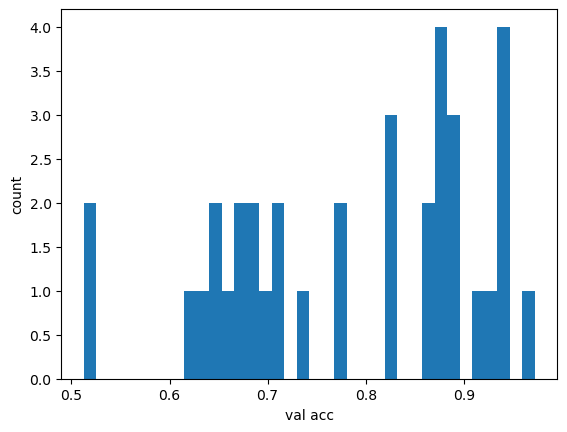

In [29]:
plt.hist(val_acc_history, bins=36);
plt.xlabel('val acc')
plt.ylabel('count');

len(val_acc_history), len(bad_sess_history), bad_sess_history
# ['200729_003',
#   '211020_002',
#   '230221_002',
#   '230221_003',
#   '201202_004',
#   '210203_004']

#### filter by auROC (deprecated)
- https://glassboxmedicine.com/2019/02/23/measuring-performance-auc-auroc/
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict
- https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score

In [143]:
## for each sess, take easiest task (isi=6k, 0 vs 90, flexible C), record val acc

ncell_keep = 15
if ncell_keep <= 15:
    C_init = 0.1
elif ncell_keep == 999:
    C_init = 0.05
# C_init = 1 # if without standard scaler z score
# C_init = 1 # RBF kernel SVM, 15 cell
# C_init = 0.1 # decode stim2_dist, 15 cell -> very bad perf


val_acc_history = []
bad_sess_history = []
for iarea in ['V1', 'LM', 'LI']:

    use_data = 'isi=6k'
    nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                        & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                    .groupby(['date', 'sess'])
                    .first().__len__())
    
    for isess in tqdm(range(nsess_iarea)):
        df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, 
                            ncell_keep=ncell_keep, filter_cell='SNR_R1_mod')
        if df_svc.cell_id.nunique() < 5:
            print(f'not enough vis cells: area={iarea}, sess={isess}')
            continue

        ref_ori_id = 4
        df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == 0))] # only decode 0 vs 90 deg
        # df_pair = df_svc[((df_svc.stim2_dist_id == 0) | (df_svc.stim2_dist_id == 4))]

        df_pair_6000 = df_pair[df_pair.isi == 6000]
        X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id, train_only=True)
        
        scaler = StandardScaler(with_mean=False, with_std=True)
        X_train_6000 = scaler.fit_transform(X_train_6000, y=y_train_6000) # supervised fit then transform

        C_current = C_init # reset C_current, then find optimal C for this area-isi-sess-ori
        niter = 0
        while niter < 4: # limit number of iteration to avoid infinite loop (can't believe I didn't foresee this)
            # clf = make_pipeline(StandardScaler(),
            #                     LinearSVC(tol=1e-5, max_iter=int(1e7), 
            #                             penalty='l1', dual='auto', C=C_current)
            #                     )
            # clf = make_pipeline(StandardScaler(),
            #                     SVC(C=C_current, kernel='rbf', gamma='scale', 
            #                         max_iter=int(1e6))
            #                     )
            # score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)

            clf = SVC(kernel='linear', 
                    C=C_current, # penalty has to be L2. NOTE: we no longer use L1 reg
                    probability=True, random_state=42,
                    max_iter=-1, 
                    decision_function_shape='ovo',
                    )
            score_val = cross_validate(clf, X_train_6000, y_train_6000, 
                                    #    cv=LeaveOneOut(), 
                                    cv=5, 
                                    scoring='roc_auc_ovo', # val auROC
                                    return_train_score=True, # train auROC
                                    )
            

            if np.mean(score_val['train_score']) - np.std(score_val['train_score']) <= 0.5: # lower errbar too low, underfit
                C_current *= 2
                niter += 1
                print(f'train acc underfit: area={iarea}, sess={isess}, isi={use_data}')
            # elif np.mean(score_val['train_score']) >= 1: # upper errbar too high, overfit
            #     C_current /= 2
            #     niter += 1
            #     print(f'train acc overfit: area={iarea}, sess={isess}, isi={use_data}')
            else:
                val_acc = np.mean(score_val['test_score']) # actually is val auROC, not acc
                val_acc_history.append(val_acc)
                if val_acc < 0.75: # NOTE: adjust according to hist
                    bad_sess = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
                    bad_sess_history.append(bad_sess)
                    print(f'bad val perf: {bad_sess}. area={iarea}, sess={isess}, isi={use_data}, C={C_current}')
                break # record res, stop searching for C

            if niter == 4: # too many tries, give up fitting
                bad_sess = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
                bad_sess_history.append(bad_sess)
                print(f'unable to fit: {bad_sess}. area={iarea}, sess={isess}, isi={use_data}, C={C_current}')

 77%|███████▋  | 17/22 [00:23<00:07,  1.41s/it]

train acc underfit: area=LM, sess=16, isi=isi=6k
train acc underfit: area=LM, sess=16, isi=isi=6k
train acc underfit: area=LM, sess=16, isi=isi=6k
train acc underfit: area=LM, sess=16, isi=isi=6k
unable to fit: area=LM, sess=16, isi=isi=6k, C=1.6


 13%|█▎        | 2/15 [00:02<00:17,  1.36s/it]

train acc underfit: area=LI, sess=1, isi=isi=6k


 20%|██        | 3/15 [00:04<00:16,  1.33s/it]

not enough vis cells: area=LI, sess=2


 33%|███▎      | 5/15 [00:06<00:13,  1.31s/it]

not enough vis cells: area=LI, sess=4


 40%|████      | 6/15 [00:07<00:11,  1.31s/it]

not enough vis cells: area=LI, sess=5


 53%|█████▎    | 8/15 [00:10<00:09,  1.33s/it]

train acc underfit: area=LI, sess=7, isi=isi=6k
train acc underfit: area=LI, sess=7, isi=isi=6k
train acc underfit: area=LI, sess=7, isi=isi=6k
train acc underfit: area=LI, sess=7, isi=isi=6k
unable to fit: area=LI, sess=7, isi=isi=6k, C=1.6


 60%|██████    | 9/15 [00:11<00:07,  1.32s/it]

not enough vis cells: area=LI, sess=8


 67%|██████▋   | 10/15 [00:13<00:06,  1.31s/it]

not enough vis cells: area=LI, sess=9


 80%|████████  | 12/15 [00:15<00:03,  1.31s/it]

not enough vis cells: area=LI, sess=11


100%|██████████| 15/15 [00:19<00:00,  1.32s/it]

not enough vis cells: area=LI, sess=14


(34,
 6,
 ['211020_002',
  '211020_003',
  '230221_002',
  '230221_003',
  '200806_003',
  '210203_004'])

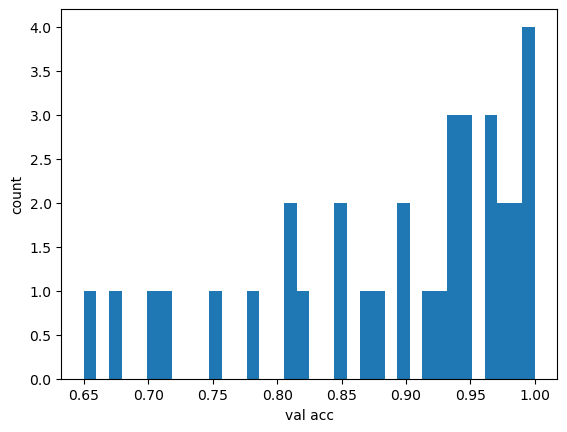

In [145]:
plt.hist(val_acc_history, bins=36);
plt.xlabel('val acc')
plt.ylabel('count');

len(val_acc_history), len(bad_sess_history), bad_sess_history
# ['200729_003',
#   '211020_002',
#   '230221_002',
#   '230221_003',
#   '201202_004',
#   '210203_004']

### filter sess rand forest

In [30]:
## for each sess, take easiest task (isi=6k, 0 vs 90), record val acc

ncell_keep = 999
val_acc_history = []
bad_sess_history = []

for iarea in ['V1', 'LM', 'LI']:

    use_data = 'isi=6k'
    nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                        & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                    .groupby(['date', 'sess'])
                    .first().__len__())
    
    for isess in tqdm(range(nsess_iarea)):
        df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, 
                            ncell_keep=ncell_keep, filter_cell='SNR_R1_mod')
        if df_svc.cell_id.nunique() < 5:
            print(f'not enough vis cells: area={iarea}, sess={isess}')
            continue

        ref_ori_id = 4
        df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == 0))] # only decode 0 vs 90 deg

        df_pair_6000 = df_pair[df_pair.isi == 6000]
        X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id, train_only=True)

        clf = make_pipeline(StandardScaler(),
                            RandomForestClassifier(n_estimators=100, # max_depth=10,
                                                   random_state=42,
                                                   bootstrap=True, oob_score=True, 
                                                   n_jobs=-1)
                            )
        clf.fit(X_train_6000, y_train_6000)
        val_acc = clf.named_steps.randomforestclassifier.oob_score_ # out of bag score, basically val acc (data left out in bootstrap / each tree)
        val_acc_history.append(val_acc)
        
        if val_acc < 0.7: # NOTE: adjust according to hist
            bad_sess = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
            bad_sess_history.append(bad_sess)

 20%|██        | 3/15 [00:04<00:17,  1.42s/it]

not enough vis cells: area=LI, sess=2


 33%|███▎      | 5/15 [00:07<00:14,  1.42s/it]

not enough vis cells: area=LI, sess=4


 40%|████      | 6/15 [00:08<00:12,  1.39s/it]

not enough vis cells: area=LI, sess=5


 60%|██████    | 9/15 [00:12<00:08,  1.42s/it]

not enough vis cells: area=LI, sess=8


 67%|██████▋   | 10/15 [00:14<00:06,  1.39s/it]

not enough vis cells: area=LI, sess=9


 80%|████████  | 12/15 [00:17<00:04,  1.40s/it]

not enough vis cells: area=LI, sess=11


100%|██████████| 15/15 [00:21<00:00,  1.43s/it]

not enough vis cells: area=LI, sess=14


(36,
 10,
 ['200729_003',
  '211020_002',
  '211020_003',
  '230221_002',
  '230221_003',
  '200806_003',
  '201202_004',
  '210203_003',
  '210203_004',
  '230228_003'])

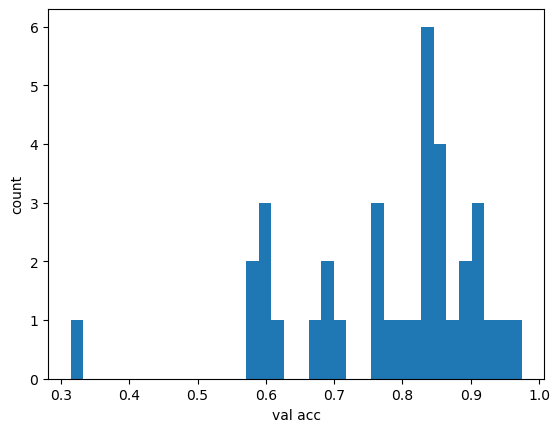

In [31]:
plt.hist(val_acc_history, bins=36);
plt.xlabel('val acc')
plt.ylabel('count');

val_acc_history = np.array(val_acc_history)
len(val_acc_history), len(val_acc_history[val_acc_history < 0.7]), bad_sess_history

# SVM cross val search reg
find optimal reg param C

## aware decoder

two separate models for two isi.  
one model: train and test with isi=6k  
another model: train and test with isi=250  

In [54]:
for iarea in ['V1']: #, 'LM', 'LI']:
    print(iarea)
    nsess = df_tidy[df_tidy.area == iarea].groupby(['date', 'sess']).__len__()
    
    for idatesess in (range(1)): # nsess
        
        # ncell_keep = 999 # check how much overfit if keep all cells
        # filter_cell = 'well_fit'
        ncell_keep = 15
        filter_cell = 'SNR_R1_mod'

        df_svc = get_df_svc(df_tidy, 
                            iarea=iarea, idatesess=idatesess, 
                            ncell_keep=ncell_keep, 
                            filter_cell=filter_cell
                            )
        
        if df_svc.cell_id.nunique() < 5:
            print(f'not enough vis cells: area={iarea}, sess={idatesess}')
            continue

        # tmp = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
        # if tmp in bad_sess_history:
        #     print(f'bad sess due to low val acc on easy task: area={iarea}, sess={idatesess}')
        #     continue

        tmp = df_svc.stim2_id.unique()
        # tmp = df_svc.stim2_dist_id.unique()
        ref_ori_id = 0 # decode which ori vs others. 0=0 deg, 4=90 deg, etc
        other_ori = sorted(tmp[tmp != ref_ori_id]) # decode task: ref vs not ref

        for use_data in ['isi=250', 'isi=6k']:
            print(use_data)

            nrow = 4
            ncol = 2
            fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

            acc_val_mean_iori = []
            acc_val_ci_iori = [] # confidence interval based on binomial distribution

            for iori in (other_ori):
                df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == iori))]
                # df_pair = df_svc[((df_svc.stim2_dist_id == ref_ori_id) | (df_svc.stim2_dist_id == iori))]
                df_pair_250 = df_pair[df_pair.isi == 250]
                df_pair_6000 = df_pair[df_pair.isi == 6000]

                ## split train vs test for each isi
                X_train_250, y_train_250, _, _ = df_to_train_test(df_pair_250, ref_ori_id, train_only=True) # no test data
                X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id, train_only=True)

                ## standard scaler normalization
                scaler = StandardScaler(with_mean=False, with_std=True)
                X_train_250 = scaler.fit_transform(X_train_250, y=y_train_250)
                X_train_6000 = scaler.fit_transform(X_train_6000, y=y_train_6000)

                ## cross validation to find optimal C
                acc_train_mean = []
                acc_train_ci = []
                acc_val_mean = []
                acc_val_ci = [] # confidence interval based on binomial distribution
                
                C_list = [1e-2 * 10**i for i in range(5)]
                # C_list = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20] # zoom in around 1
                # C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
                for C_val in tqdm(C_list):
                    
                    clf = make_pipeline(StandardScaler(),
                                        LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                                penalty='l1', dual=False, C=C_val)
                    #                     # SVC(C=C_val, kernel='rbf', gamma='auto', 
                    #                     #     max_iter=int(1e6))
                                        )
                    # clf = SVC(kernel='linear', 
                    #         C=C_val, # penalty has to be L2. NOTE: we no longer use L1 reg
                    #         probability=True, random_state=42,
                    #         max_iter=-1, 
                    #         decision_function_shape='ovo',
                    #         )
                    
                    if use_data == 'isi=250':
                        score_val = cross_validate(clf, X_train_250, y_train_250, cv=LeaveOneOut(), return_train_score=True)
                        # score_val = cross_validate(clf, X_train_250, y_train_250, 
                        #                     #    cv=LeaveOneOut(), 
                        #                     cv=5, 
                        #                     scoring='roc_auc_ovo', # val auROC
                        #                     return_train_score=True, # train auROC
                        #                     )
                    
                    elif use_data == 'isi=6k':
                        score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)
                        # score_val = cross_validate(clf, X_train_6000, y_train_6000, 
                        #                     #    cv=LeaveOneOut(), 
                        #                     cv=5, 
                        #                     scoring='roc_auc_ovo', # val auROC
                        #                     return_train_score=True, # train auROC
                        #                     )
                    
                    ## from here on, if using scoring='roc_auc_ovo', then acc_xx is actually auROC_xx
                    acc_train_mean.append(np.mean(score_val['train_score']))
                    ci_low, ci_high = proportion_confint(count=score_val['train_score'].sum(), nobs=len(score_val['train_score']))
                    acc_train_ci.append((ci_high - ci_low) / 2)
                    # acc_train_ci.append(np.std(score_val['train_score']))
                    
                    acc_val_mean.append(np.mean(score_val['test_score']))
                    ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
                    acc_val_ci.append((ci_high - ci_low) / 2)
                    # acc_val_ci.append(np.std(score_val['test_score']))
                    
                acc_val_mean_iori.append(acc_val_mean)
                acc_val_ci_iori.append(acc_val_ci)
                    
                    
                ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                            yerr=acc_train_ci, fmt='o', capsize=5, capthick=2, label='train', alpha=0.5)
                ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                            yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val', alpha=0.5)
                
                ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='gray', alpha=0.2, label='chance')
                ax[int(iori/ncol), iori%ncol].axhline(y=1, color='k', alpha=0.2, label='1')

                ax[int(iori/ncol), iori%ncol].set_xscale('log') # set x axis to log scale
                ax[int(iori/ncol), iori%ncol].legend(frameon=False);
                ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs {22.5*ref_ori_id} deg');
                ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
                ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
                
            plt.tight_layout()
            dir_fig = os.path.join(dir_repo, r'results/decoder_grat8/decoder_grat_2ori/'.replace('\\', '/'))
            if not os.path.exists(dir_fig): # mkdir if not exist
                os.makedirs(dir_fig)
            fig.savefig(dir_fig + f'aware_decoder_2ori_{use_data}_{filter_cell}_{ncell_keep}_{iarea}_{idatesess}.pdf', bbox_inches='tight')
            plt.close(fig)
        
        
            # fix_C = 1
            # acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
            # acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
            # stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']

            # plt.errorbar(x=np.arange(len(stim2_ori_list)), 
            #             y=acc_val_C, 
            #             yerr=acc_val_ci_C, 
            #             fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);

            # stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
            # plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
            # plt.xlabel('stim2_ori')
            # plt.ylabel(f'acc_val');

            # title_str = f'aware decoder stim2_dist, C={fix_C}, {use_data}, {filter_cell}_{iarea}_{idatesess}'
            # plt.title(title_str);
            # plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')
            # plt.close()

V1
isi=250


100%|██████████| 5/5 [00:10<00:00,  2.01s/it]


isi=6k


100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


### aware decoder neighbor

In [198]:
neighbor_ori_pair = {1:0, 2:1, 3:2, 4:3, # decode 22 vs 0, 45 vs 22, ... 90 vs 67
                    7:0, 6:7, 5:6, 4:5,} # decode -22 vs 0, -45 vs -22, ... -90 vs -67 

for iarea in ['V1', 'LM', 'LI']:
    print(iarea)
    nsess = df_tidy[df_tidy.area == iarea].groupby(['date', 'sess']).__len__()
    
    for idatesess in tqdm(range(5)): # nsess
        
        ncell_keep = 999 # check how much overfit if keep all cells
        filter_cell = 'vis_pval'

        df_svc = get_df_svc(df_tidy, 
                            iarea=iarea, idatesess=idatesess, 
                            ncell_keep=ncell_keep, 
                            filter_cell=filter_cell
                            )
        if df_svc.cell_id.nunique() < 5:
            print(f'not enough vis cells: area={iarea}, sess={idatesess}')
            continue
        tmp = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
        if tmp in bad_sess_history:
            print(f'bad sess due to low val acc on easy task: area={iarea}, sess={idatesess}')
            continue


        for use_data in ['isi=250', 'isi=6k']:
            print(use_data)

            nrow = 4
            ncol = 2
            fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

            acc_val_mean_iori = []
            acc_val_ci_iori = [] # confidence interval based on binomial distribution

            for iori in neighbor_ori_pair.keys():
                df_pair = df_svc[((df_svc.stim2_id == neighbor_ori_pair[iori]) | (df_svc.stim2_id == iori))]
                df_pair_250 = df_pair[df_pair.isi == 250]
                df_pair_6000 = df_pair[df_pair.isi == 6000]

                ## split train vs test for each isi
                X_train_250, y_train_250, _, _ = df_to_train_test(df_pair_250, ref_ori_id=iori, train_only=True) # no test data
                X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id=iori, train_only=True)

                ## standard scaler normalization
                scaler = StandardScaler(with_mean=False, with_std=True)
                X_train_250 = scaler.fit_transform(X_train_250, y=y_train_250)
                X_train_6000 = scaler.fit_transform(X_train_6000, y=y_train_6000)

                ## cross validation to find optimal C
                acc_train_mean = []
                acc_train_ci = []
                acc_val_mean = []
                acc_val_ci = [] # confidence interval based on binomial distribution
                
                # C_list = [1e-2 * 10**i for i in range(5)]
                # C_list = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20] # zoom in around 1
                C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
                for C_val in C_list:
                    
                    clf = make_pipeline(StandardScaler(),
                                        LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                                penalty='l1', dual=False, C=C_val)
                    #                     # SVC(C=C_val, kernel='rbf', gamma='auto', 
                    #                     #     max_iter=int(1e6))
                                        )
                    # clf = SVC(kernel='linear', 
                    #         C=C_val, # penalty has to be L2. NOTE: we no longer use L1 reg
                    #         probability=True, random_state=42,
                    #         max_iter=-1, 
                    #         decision_function_shape='ovo',
                    #         )
                    
                    if use_data == 'isi=250':
                        score_val = cross_validate(clf, X_train_250, y_train_250, cv=LeaveOneOut(), return_train_score=True)
                        # score_val = cross_validate(clf, X_train_250, y_train_250, 
                        #                     #    cv=LeaveOneOut(), 
                        #                     cv=5, 
                        #                     scoring='roc_auc_ovo', # val auROC
                        #                     return_train_score=True, # train auROC
                        #                     )
                    
                    elif use_data == 'isi=6k':
                        score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)
                        # score_val = cross_validate(clf, X_train_6000, y_train_6000, 
                        #                     #    cv=LeaveOneOut(), 
                        #                     cv=5, 
                        #                     scoring='roc_auc_ovo', # val auROC
                        #                     return_train_score=True, # train auROC
                        #                     )
                    
                    ## from here on, if using scoring='roc_auc_ovo', then acc_xx is actually auROC_xx
                    acc_train_mean.append(np.mean(score_val['train_score']))
                    ci_low, ci_high = proportion_confint(count=score_val['train_score'].sum(), nobs=len(score_val['train_score']))
                    acc_train_ci.append((ci_high - ci_low) / 2)
                    # acc_train_ci.append(np.std(score_val['train_score']))
                    
                    acc_val_mean.append(np.mean(score_val['test_score']))
                    ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
                    acc_val_ci.append((ci_high - ci_low) / 2)
                    # acc_val_ci.append(np.std(score_val['test_score']))
                    
                acc_val_mean_iori.append(acc_val_mean)
                acc_val_ci_iori.append(acc_val_ci)
                    
                    
                ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                            yerr=acc_train_ci, fmt='o', capsize=5, capthick=2, label='train', alpha=0.5)
                ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                            yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val', alpha=0.5)
                
                ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='gray', alpha=0.2, label='chance')
                ax[int(iori/ncol), iori%ncol].axhline(y=1, color='k', alpha=0.2, label='1')

                ax[int(iori/ncol), iori%ncol].set_xscale('log') # set x axis to log scale
                ax[int(iori/ncol), iori%ncol].legend(frameon=False);
                ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs {int(22.5*neighbor_ori_pair[iori])} deg');
                ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
                ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
                
            plt.tight_layout()
            dir_fig = os.path.join(dir_repo, r'results/decoder_grat8/aware decoder/neighbor, C param tuning/'.replace('\\', '/'))
            if not os.path.exists(dir_fig): # mkdir if not exist
                os.makedirs(dir_fig)
            fig.savefig(dir_fig + f'aware_decoder_{use_data}_{filter_cell}_{iarea}_{idatesess}.pdf', bbox_inches='tight')
            plt.close(fig)

V1


  0%|          | 0/5 [00:00<?, ?it/s]

isi=250
isi=6k


 20%|██        | 1/5 [00:15<01:02, 15.69s/it]

isi=250
isi=6k


 40%|████      | 2/5 [00:32<00:48, 16.17s/it]

isi=250


c:\Users\ll357\AppData\Local\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


isi=6k


 60%|██████    | 3/5 [00:49<00:33, 16.65s/it]

isi=250
isi=6k


 80%|████████  | 4/5 [01:05<00:16, 16.38s/it]

isi=250
isi=6k


100%|██████████| 5/5 [01:21<00:00, 16.31s/it]


LM


  0%|          | 0/5 [00:00<?, ?it/s]

isi=250
isi=6k


 40%|████      | 2/5 [00:16<00:20,  6.97s/it]

bad sess due to low val acc on easy task: area=LM, sess=1
isi=250
isi=6k


 60%|██████    | 3/5 [00:32<00:22, 11.31s/it]

isi=250
isi=6k


 80%|████████  | 4/5 [00:46<00:12, 12.36s/it]

isi=250
isi=6k


100%|██████████| 5/5 [01:01<00:00, 12.34s/it]


LI


  0%|          | 0/5 [00:00<?, ?it/s]

isi=250
isi=6k


 40%|████      | 2/5 [00:16<00:21,  7.01s/it]

bad sess due to low val acc on easy task: area=LI, sess=1


 60%|██████    | 3/5 [00:17<00:08,  4.43s/it]

not enough vis cells: area=LI, sess=2


 80%|████████  | 4/5 [00:19<00:03,  3.21s/it]

bad sess due to low val acc on easy task: area=LI, sess=3


100%|██████████| 5/5 [00:20<00:00,  4.10s/it]

not enough vis cells: area=LI, sess=4


## xp unaware decoder
train with both, test with either - assume decoder learned from visual xp

In [55]:
for iarea in ['V1']:
            #   , 'LM', 'LI']:
    print(iarea)
    nsess = df_tidy[df_tidy.area == iarea].groupby(['date', 'sess']).__len__()
    
    for idatesess in (range(1)): # nsess

        # ncell_keep = 999 # check how much overfit if keep all cells
        # filter_cell = 'well_fit'
        ncell_keep = 15
        filter_cell = 'SNR_R1_mod'

        df_svc = get_df_svc(df_tidy, 
                            iarea=iarea, idatesess=idatesess, 
                            ncell_keep=ncell_keep, 
                            filter_cell=filter_cell
                            )
        # if df_svc.cell_id.nunique() < 5:
        #     print(f'not enough vis cells: area={iarea}, sess={idatesess}')
        #     continue
        # tmp = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
        # if tmp in bad_sess_history: # for xp unaware decoder, inherit bad sess from aware decoder
        #     print(f'bad sess due to low val acc on easy task: area={iarea}, sess={idatesess}')
        #     continue

        tmp = df_svc.stim2_id.unique()
        ref_ori_id = 0 # decode which ori vs others. 0=0 deg, 4=90 deg, etc
        other_ori = sorted(tmp[tmp != ref_ori_id]) # decode ref vs not ref

        for use_data in ['isi=250', 'isi=6k']:
            print(use_data)

            nrow = 4
            ncol = 2
            fig, ax = plt.subplots(4, 2, figsize=(12, 20), sharey=True)

            acc_val_mean_iori = []
            acc_val_ci_iori = [] # confidence interval based on binomial distribution

            for iori in (other_ori):
                df_pair = df_svc[((df_svc.stim2_id == ref_ori_id) | (df_svc.stim2_id == iori))]
                X_train, y_train, _, _ = df_to_train_test(df_pair, ref_ori_id, train_only=True)

                ## cross validation to find optimal C
                acc_train_mean = []
                acc_train_ci = []
                acc_val_mean = []
                acc_val_ci = [] # confidence interval based on binomial distribution
                
                C_list = [1e-2 * 10**i for i in range(5)]
                # C_list = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20] # zoom in around 1
                # C_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1] # zoom in around 0.1
                for C_val in tqdm(C_list):
                    
                    clf = make_pipeline(StandardScaler(),
                                        LinearSVC(tol=1e-5, max_iter=int(1e6), 
                                                penalty='l1', dual=False, C=C_val)
                                        # SVC(C=C_val, kernel='rbf', gamma='auto', 
                                        #     max_iter=int(1e6))
                                        )
                    
                    score_val = cross_validate(clf, X_train, y_train, cv=LeaveOneOut(), return_train_score=True)

                    ## LeaveOneOut() keeps the order of train data. inherit ISI info from df_to_train_test(df_pair...) & separately calculate acc for each ISI
                    isi_arr = df_pair.groupby('trial_id').isi.first().values # same as how we get label_arr (y_train) in df_to_train_test
                    if use_data == 'isi=250':
                        score_val['train_score'] = score_val['train_score'][isi_arr==250]
                        score_val['test_score'] = score_val['test_score'][isi_arr==250]
                    elif use_data == 'isi=6k':
                        score_val['train_score'] = score_val['train_score'][isi_arr==6000]
                        score_val['test_score'] = score_val['test_score'][isi_arr==6000]

                    
                    acc_train_mean.append(np.mean(score_val['train_score']))
                    ci_low, ci_high = proportion_confint(count=score_val['train_score'].sum(), nobs=len(score_val['train_score']))
                    acc_train_ci.append((ci_high - ci_low) / 2)
                    
                    acc_val_mean.append(np.mean(score_val['test_score']))
                    ci_low, ci_high = proportion_confint(count=score_val['test_score'].sum(), nobs=len(score_val['test_score']))
                    acc_val_ci.append((ci_high - ci_low) / 2)
                    
                acc_val_mean_iori.append(acc_val_mean)
                acc_val_ci_iori.append(acc_val_ci)
                    
                    
                ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_train_mean, 
                            yerr=acc_train_ci, fmt='o', capsize=5, capthick=2, label='train', alpha=0.5)
                ax[int(iori/ncol), iori%ncol].errorbar(x=C_list, y=acc_val_mean,
                            yerr=acc_val_ci, fmt='o', capsize=5, capthick=2, label='val', alpha=0.5)
                
                ax[int(iori/ncol), iori%ncol].axhline(y=0.5, color='gray', alpha=0.2, label='chance')
                ax[int(iori/ncol), iori%ncol].axhline(y=1, color='k', alpha=0.2, label='1')

                ax[int(iori/ncol), iori%ncol].set_xscale('log') # set x axis to log scale
                ax[int(iori/ncol), iori%ncol].legend(frameon=False);
                ax[int(iori/ncol), iori%ncol].set_title(f'decoder: {int(22.5*iori)} vs {22.5*ref_ori_id} deg');
                ax[int(iori/ncol), iori%ncol].set_xlabel('more reg ... <-- C --> ... less reg');
                ax[int(iori/ncol), iori%ncol].set_ylabel('accuracy');
                
            fig.tight_layout()
            dir_fig = os.path.join(dir_repo, r'results/decoder_grat8/decoder_grat_2ori/'.replace('\\', '/'))
            if not os.path.exists(dir_fig): # mkdir if not exist
                os.makedirs(dir_fig)
            fig.savefig(dir_fig + f'xp_unaware_decoder_2ori_{use_data}_{filter_cell}_{ncell_keep}_{iarea}_{idatesess}.pdf', bbox_inches='tight')
            plt.close(fig)
        
        
            # fix_C = 1
            # acc_val_C = np.array(acc_val_mean_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
            # acc_val_ci_C = np.array(acc_val_ci_iori)[:, np.where(np.array(C_list)==fix_C)[0][0]]
            # stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']

            # plt.errorbar(x=np.arange(len(stim2_ori_list)), 
            #             y=acc_val_C, 
            #             yerr=acc_val_ci_C, 
            #             fmt='o', color='b', alpha=0.5, ecolor='lightgray', elinewidth=3, capsize=0);

            # stim2_ori_list = ['0', '22.5', '45', '67.5', '112.5', '135', '157.5']
            # plt.xticks(np.arange(len(stim2_ori_list)), stim2_ori_list);
            # plt.xlabel('stim2_ori')
            # plt.ylabel(f'acc_val');

            # title_str = f'aware decoder stim2_dist, C={fix_C}, {use_data}, {filter_cell}_{iarea}_{idatesess}'
            # plt.title(title_str);
            # plt.savefig(dir_fig + f'{title_str}.pdf', bbox_inches='tight')
            # plt.close()

V1
isi=250


100%|██████████| 5/5 [00:23<00:00,  4.79s/it]


isi=6k


100%|██████████| 5/5 [00:23<00:00,  4.78s/it]


# decoder across isi
area subplot, isi color, date_sess concat acc errorbar  
fixed C

## aware decoder neighbor

In [118]:
decoder_type = 'linear SVM'
neighbor_ori_pair = {1:0, 2:1, 3:2, 4:3, # decode 22 vs 0, 45 vs 22, ... 90 vs 67
                    7:0, 6:7, 5:6, 4:5,} # decode -22 vs 0, -45 vs -22, ... -90 vs -67
ncell_keep = 15
filter_cell = 'SNR_R1_mod' # TODO: try well-max
C_init = 0.1


if decoder_type == 'random forest':
    df_perf = pd.DataFrame(columns=['area', 'isi', 'sess', 'ori', 
                                    'true_pos', 'n_sample', 'val_acc', # three var for val acc
                                    ])
elif decoder_type == 'linear SVM':
    df_perf = pd.DataFrame(columns=['area', 'isi', 'sess', 'ori', 
                                    'true_pos', 'n_sample', 'val_acc', # three var for val acc
                                    'true_pos_train', 'n_sample_train', 'train_acc', # three var for train acc
                                    'C', 'bad_fit'])
    
for iarea in ['V1',]:
    print(iarea)

    for use_data in ['isi=250', 'isi=6k']:
        nsess_iarea = (df_tidy[(df_tidy.area == iarea) 
                            & (df_tidy.filter_cell_vis == True)] # some LI sessions have no vis cell
                        .groupby(['date', 'sess'])
                        .first().__len__())
        
        for isess in tqdm(range(nsess_iarea)):
            df_svc = get_df_svc(df_tidy, iarea=iarea, idatesess=isess, 
                                ncell_keep=ncell_keep, 
                                filter_cell=filter_cell)
            # if df_svc.cell_id.nunique() < 5:
            #     print(f'not enough vis cells: area={iarea}, sess={isess}')
            #     continue
            # tmp = (df_svc.date.unique() + '_' + df_svc.sess.unique())[0]
            # if tmp in bad_sess_history:
            #     print(f'bad sess due to low val acc on easy task: area={iarea}, sess={isess}')
            #     continue # NOTE: don't skip bad sess, bc we switched to neighbor ori pair

            for iori in (other_ori):
                df_pair = df_svc[((df_svc.stim2_id == neighbor_ori_pair[iori]) | (df_svc.stim2_id == iori))]
                df_pair_250 = df_pair[df_pair.isi == 250]
                df_pair_6000 = df_pair[df_pair.isi == 6000]

                X_train_250, y_train_250, _, _ = df_to_train_test(df_pair_250, ref_ori_id=iori, train_only=True) # no test data
                X_train_6000, y_train_6000, _, _ = df_to_train_test(df_pair_6000, ref_ori_id=iori, train_only=True)

                ## standard scaler normalization
                scaler = StandardScaler(with_mean=False, with_std=True)
                X_train_250 = scaler.fit_transform(X_train_250, y=y_train_250)
                X_train_6000 = scaler.fit_transform(X_train_6000, y=y_train_6000)

                if decoder_type == 'random forest':
                    clf = make_pipeline(StandardScaler(),
                                        RandomForestClassifier(n_estimators=100,
                                                            random_state=42,
                                                            bootstrap=True, oob_score=True, 
                                                            n_jobs=-1)
                                        )
                    
                    if use_data == 'isi=250':
                        clf.fit(X_train_250, y_train_250)
                        n_sample = len(y_train_250)
                    elif use_data == 'isi=6k':
                        clf.fit(X_train_6000, y_train_6000)
                        n_sample = len(y_train_6000)

                    val_acc = clf.named_steps.randomforestclassifier.oob_score_
                    true_pos = val_acc * n_sample
                    df_newline = pd.DataFrame({'area': iarea, 'isi': use_data, 'sess': isess, 'ori': iori,
                                                'true_pos': true_pos, 'n_sample': n_sample, 
                                                'val_acc': val_acc
                                                }, 
                                                columns=df_perf.columns, 
                                                index=[0])
                    df_perf = pd.concat([df_newline, df_perf], ignore_index=True)


                elif decoder_type == 'linear SVM':
                    C_current = C_init # reset C_current, then find optimal C for this area-isi-sess-ori
                    niter = 0
                    max_iter = 4
                    while niter < max_iter: # limit number of iteration to avoid infinite loop (can't believe I didn't foresee this)
                        clf = make_pipeline(StandardScaler(),
                                            LinearSVC(tol=1e-5, max_iter=int(1e7), 
                                                    penalty='l1', dual='auto', C=C_current))
                        # clf = SVC(kernel='linear', 
                        #     C=C_val, # penalty has to be L2. NOTE: this no longer use L1 reg
                        #     probability=True, random_state=42,
                        #     max_iter=-1, 
                        #     decision_function_shape='ovo',
                        #     )
                        # clf = LinearSVC(max_iter=int(1e7), 
                        #                 penalty='l1', dual='auto', C=C_current)
                        # nfold = 5

                        if use_data == 'isi=250':
                            # score_val = cross_validate(clf, X_train_250, y_train_250, cv=LeaveOneOut(), return_train_score=True)
                            X_train = X_train_250.copy()
                            y_train = y_train_250.copy()
                        elif use_data == 'isi=6k':
                            # score_val = cross_validate(clf, X_train_6000, y_train_6000, cv=LeaveOneOut(), return_train_score=True)
                            X_train = X_train_6000.copy()
                            y_train = y_train_6000.copy()
                        score_val = cross_validate(clf, X_train, y_train, 
                                                    cv=LeaveOneOut(), 
                                                    # cv=nfold, 
                                                    # scoring='roc_auc_ovo', # val auROC
                                                    return_train_score=True, # train auROC
                                                    )

                        ## from here on, if using scoring='roc_auc_ovo', then acc_xx is actually auROC_xx
                        if (np.mean(score_val['train_score']) <= 0.5) or (np.mean(score_val['test_score']) <= 0.5): # acc is too low, underfit
                            C_current *= 2
                            niter += 1
                            print(f'train acc underfit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}')
                        elif np.min(score_val['train_score']) >= 1: # NOTE: had to relax from mean to min, somehow very easy to get train auROC=1
                            C_current /= 2
                            niter += 1
                            print(f'train acc overfit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}')
                        else:
                            break # record res, stop searching for C

                    ## outside of while loop, record res
                    # n_sample = len(y_train) / nfold
                    # true_pos = score_val['test_score'].mean() * n_sample
                    # n_sample_train = len(y_train) - n_sample
                    # true_pos_train = score_val['train_score'].mean() * n_sample_train
                    true_pos = score_val['test_score'].sum()
                    n_sample = len(score_val['test_score'])
                    n_sample_train = n_sample - 1 # leave one out (LOO)
                    true_pos_train = score_val['train_score'].mean() * n_sample_train # mean train acc across LOO attempts

                    bad_fit = False
                    if niter == max_iter: # too many tries, this is a bad fit
                        print(f'unable to fit: area={iarea}, sess={isess}, isi={use_data}, ori={iori}, C={C_current}')
                        bad_fit = True

                    df_newline = pd.DataFrame({'area': iarea, 'isi': use_data, 'sess': isess, 'ori': iori,
                                                'true_pos': true_pos, 'n_sample': n_sample, 
                                                'val_acc': np.mean(score_val['test_score']), 
                                                'true_pos_train': true_pos_train, 'n_sample_train': n_sample_train, 
                                                'train_acc': np.mean(score_val['train_score']),
                                                'C': C_current, 'bad_fit': bad_fit}, 
                                                columns=df_perf.columns, 
                                                index=[0])
                    df_perf = pd.concat([df_newline, df_perf], ignore_index=True)

## 3 min to run linear SVM, ? min to run random forest

V1


100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


In [121]:
df_perf

,area,isi,sess,ori,true_pos,n_sample,val_acc,true_pos_train,n_sample_train,train_acc,C,bad_fit
0,V1,isi=6k,0,1,490.0,779,0.629012,501.453145,778,0.644541,0.1,False
1,V1,isi=250,0,1,440.0,777,0.566281,461.320463,776,0.594485,0.1,False


## errorbar as binomial CI

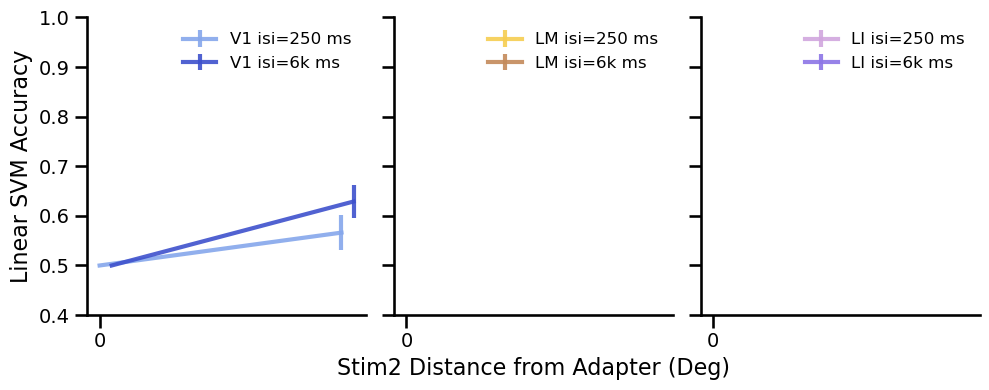

In [129]:
plot_perf = 'val'
df_perf['ori_dist_id'] = df_perf.ori.apply(lambda x: stim2_dict[x])

if plot_perf == 'val':
    tmp = df_perf.groupby(['area', 'isi', 'ori_dist_id'])[['true_pos', 'n_sample']].sum().reset_index()
    tmp['acc'] = tmp.true_pos / tmp.n_sample
    tmp['ci'] = tmp.apply(lambda x: proportion_confint(count=x.true_pos, nobs=x.n_sample), axis=1)
    tmp['err'] = tmp.apply(lambda x: (x.ci[1] - x.ci[0]) / 2, axis=1)

elif plot_perf == 'train':
    tmp = df_perf.groupby(['area', 'isi', 'ori_dist_id'])[['true_pos_train', 'n_sample_train']].sum().reset_index()
    tmp['acc'] = tmp.true_pos_train / tmp.n_sample_train
    tmp['ci'] = tmp.apply(lambda x: proportion_confint(count=x.true_pos_train, nobs=x.n_sample_train), axis=1)
    tmp['err'] = tmp.apply(lambda x: (x.ci[1] - x.ci[0]) / 2, axis=1)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6'
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]

fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
for (i, iarea) in enumerate(['V1', 'LM', 'LI']):
    for (j, iisi) in enumerate(['isi=250', 'isi=6k', ]):
        
        tmp1 = tmp[(tmp.area == iarea) & (tmp.isi == iisi)].acc.values
        tmp2 = tmp[(tmp.area == iarea) & (tmp.isi == iisi)].err.values

        ## insert chance level acc to start of array (where ori_dist_id = 0)
        tmp1 = np.insert(tmp1, 0, 0.5)
        tmp2 = np.insert(tmp2, 0, 0)
        
        ax[i].errorbar(x=np.arange(len(tmp1)) + j*0.05, 
                    y=tmp1, 
                    yerr=tmp2, 
                    # fmt='o', 
                    linewidth=3,
                    alpha=0.9, 
                    label=f'{iarea} {iisi} ms', 
                    color=color_list[i*2+j], #ecolor='lightgray', elinewidth=3, capsize=0
                    );

    
    ax[i].set_xticks(np.arange(len(tmp1)));
    # if ref_ori_id == 0:
    #     ax[i].set_xticklabels(['0', '22.5', '45', '67.5', '90']);
    # elif ref_ori_id == 4:
    #     ax[i].set_xticklabels(['90', '67.5', '45', '22.5']);
    ax[i].tick_params(axis='both', which='major', labelsize=14)
    ax[i].set_ylim(0.4, 1);
    ax[i].legend(frameon=False, loc='upper right', fontsize=12);
    # ax[i].set_title(iarea);

ax[0].set_ylabel('Linear SVM Accuracy', fontsize=16);
ax[1].set_xlabel('Stim2 Distance from Adapter (Deg)', fontsize=16);
    
# plt.suptitle(f'err=binom, {plot_perf} acc')
plt.tight_layout();
sns.despine();
dir_fig = os.path.join(dir_repo, r'results\decoder_grat8/'.replace('\\', '/'))
# fig.savefig(dir_fig + 'aware_decoder_large_ntrial.svg', bbox_inches='tight')

# fig4: decorr

## read csv for well-max

In [56]:
# dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
# # df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv'), index=False) # takes 80 sec
# df_tidy = pd.read_csv(os.path.join(dir_data, 'df_tidy_tuning_bias_wellmax.csv')) # 9 sec
df_tidy.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_vis_pval,filter_cell_stim,mouse,date,sess,stim2_dist_id,filter_cell_well_fit
200785,0.079458,240206_003_66,187,R2,250,1,0,V1,0,True,3.289156e-16,True,1380,240206,003,0,NaN
80419,0.013861,240206_003_103,779,R1,250,1,1,V1,0,True,3.298843e-14,True,1380,240206,003,1,NaN
270833,0.000347,240206_003_111,215,R2,6000,0,1,V1,0,False,4.697552e-14,False,1380,240206,003,1,NaN
204754,0.053211,240206_003_68,1044,R2,250,1,1,V1,0,True,3.470334e-30,True,1380,240206,003,1,NaN
72266,-0.008494,240206_003_93,9,R1,250,1,1,V1,0,False,1.894864e-12,False,1380,240206,003,1,NaN


## bootstrap for decorr

In [67]:
pd.options.mode.chained_assignment = None  # default='warn' # suppress SettingWithCopyWarning

def get_df_decorr(df_tidy, current_area, filter_cell=None):
    ## TODO: add back filter cell well_fit, well_max
    df_decorr = df_tidy[['dfof', 
                        'cell_id', 'resp_id', 'isi', 'stim2_id', 'trial_id', 
                        'filter_cell_vis', 'filter_cell_stim', # 'filter_cell_well_fit', 'filter_cell_well_max',
                        'area', 'mouse', 'date', 'sess'
                        ]]

    df_decorr['stim2_dist'] = df_decorr.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                              # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
    
    df_decorr['date_sess'] = df_decorr.date.astype(str) + '_' + df_decorr.sess.astype(str)
    df_decorr['trial_id'] = df_decorr['date_sess'] + '_' + df_decorr['trial_id'].astype(str) # make trial_id unique across datesess

    df_decorr = df_decorr[(df_decorr.isi != 750)
                          & (df_decorr.resp_id == 'R2') # repre of 8ori, with or without 0 deg adapter
                          & (df_decorr.area == current_area)
                          & (df_decorr.filter_cell_vis == True)
                         ]
    if filter_cell == 'well_fit':
        df_decorr = df_decorr[(df_decorr.filter_cell_well_fit == True)]
    elif filter_cell == 'well_max':
        well_max_cell = df_decorr[(df_decorr.filter_cell_well_max == True)].cell_id.unique() # NOTE: well_max is for each cell and isi
        df_decorr = df_decorr[df_decorr.cell_id.isin(well_max_cell)]
    
    return df_decorr

In [68]:
def sim_sess(df_decorr, ref_ori=90, metric='cos_sim'):
    df_sim = pd.DataFrame(columns=['isi', 'stim2_dist', 'date_sess', 'sim'])
    sim_across_sess = []
    for idatesess in tqdm(df_decorr.date_sess.unique()):

        ## discard if not enough ncell (when using well-max filter)
        if df_decorr[df_decorr.date_sess == idatesess].cell_id.nunique() <= 10: 
            continue
        
        df_pop_vec = (df_decorr[df_decorr.date_sess == idatesess]
                    .groupby(['isi', 'stim2_dist', 'cell_id'])
                    .dfof.mean().reset_index()
                    .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof')
                    ) # rows: isi 250 -> 6000, within each isi, stim2_dist 0 -> 90. cols: cell_id
        nori = df_decorr.stim2_dist.nunique()
        nisi_now = df_decorr.isi.nunique() # discarded isi 750
        # isi_list = df_decorr.isi.unique()
        isi_list = [250, 6000] # same as df_pop_vec isi order

        sim_isess = []
        for iisi in range(nisi_now):
            if ref_ori == 90:
                iref = iisi*nori + 4  # -1 (0-based indexing) and +1 (go to next isi) cancel out
                pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: ref ori target resp
            elif ref_ori == 0:
                iref = iisi*nori
                pop_vec_ref = df_pop_vec.iloc[iref, :].values

            for iori in range(nori): # iori = 0-4, aka ori distance from ref ori
                irow = iisi * nori + iori
                pop_vec_ori = df_pop_vec.iloc[irow, :].values

                if ref_ori == 'neighbor':
                    if iori > 0:
                        pop_vec_ref = df_pop_vec.iloc[irow-1, :].values # take the previous ori (aka left neighbor) as ref
                    else:
                        pop_vec_ref = pop_vec_ori.copy() # for iori = 0, ref is itself

                if metric == 'cos_sim':
                    sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
                elif metric == 'dot_prod':
                    sim = dot(pop_vec_ref, pop_vec_ori)
                elif metric == 'neural_angle':
                    tmp = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
                    tmp = np.round(tmp, 4) # prevent numerical error like 1.0000000000000002
                    sim = np.arccos(tmp) * 180 / np.pi # cos_simil to simil rad to deg, "neural angle"
                    
                df_sim = pd.concat([df_sim, pd.DataFrame({'isi': isi_list[iisi], 'stim2_dist': iori, 'date_sess': idatesess, 'sim': sim}, index=[0])])
                sim_isess.append(sim)
        sim_across_sess.append(sim_isess) # n of decorrelation pairs (nisi * nori)    
    sim_across_sess = np.array(sim_across_sess) # n of boot x n of decorrelation pairs (nisi * nori). NOTE: isi order is 250 -> 6000
    return sim_across_sess, df_sim

In [70]:
# ### well max filter

# df_decorr_V1 = get_df_decorr(df_tidy, current_area='V1', filter_cell='well_max')
# df_decorr_LM = get_df_decorr(df_tidy, current_area='LM', filter_cell='well_max')
# df_decorr_LI = get_df_decorr(df_tidy, current_area='LI', filter_cell='well_max')

df_decorr_V1 = get_df_decorr(df_tidy, current_area='V1', filter_cell=None)
cos_sim_V1_neighbor_sess, df_cossim_V1_neighbor_sess = sim_sess(df_decorr_V1, ref_ori='neighbor', metric='cos_sim')
dot_prod_V1_neighbor_sess, df_prod_V1_neighbor_sess = sim_sess(df_decorr_V1, ref_ori='neighbor', metric='dot_prod')

100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


### noise

In [73]:
def snr_pop_vec_sess_1trial(df_decorr):
    df_noise = pd.DataFrame(columns=['isi', 'stim2_dist', 'date_sess', 'noise'])
    noise_sess = []
    for idatesess in tqdm(df_decorr.date_sess.unique()):
        
        ## discard if not enough ncell (when using well-max filter)
        if df_decorr[df_decorr.date_sess == idatesess].cell_id.nunique() <= 5: 
            continue

        df_decorr_sess = df_decorr[df_decorr.date_sess == idatesess]
        ncell_sess = df_decorr_sess.cell_id.nunique()

        ## get pop_vec_avg of each isi-stim2_dist condition
        df_pop_vec_agg = (df_decorr_sess
                            .groupby(['isi', 'stim2_dist', 'cell_id'])
                            .dfof.mean().reset_index() # cell-level agg, under each isi-stim2_dist condition
                            .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof') # df allows duplicate columns
                            )
        
        ## get pop_vec of single trials
        noise_isess = [] # noise in sess, across isi-stim2_dist condition
        isi_arr = np.array([250, 6000]) # isi is sorted in df_pop_vec_agg due to pivot_table
        stim2_dist_arr = np.arange(0, 22.5+1, 22.5)

        for iisi, isi_val in enumerate(isi_arr):
            for idist, dist_val in enumerate(stim2_dist_arr):
                pop_vec_1trial_cond = (df_decorr_sess[(df_decorr_sess.isi == isi_val) 
                                                        & (df_decorr_sess.stim2_dist == dist_val)]
                                                        .pivot_table(index='trial_id', columns='cell_id', values='dfof')
                                                        .values) # ntrial x ncell
                pop_vec_agg_cond = df_pop_vec_agg.loc[(isi_val, dist_val), :].values # 1 x ncell
                noise = pop_vec_1trial_cond - pop_vec_agg_cond
                noise_across_trial = np.mean(noise, axis=0) # avg across trials
                noise_norm = np.linalg.norm(noise_across_trial) / np.sqrt(ncell_sess) # linalg.norm across cells (pop vec), then normalize by sqrt(ncell)
                
                noise_isess.append(noise_norm)
                df_noise = pd.concat([df_noise, pd.DataFrame({'isi': isi_val, 'stim2_dist': dist_val, 'date_sess': idatesess, 'noise': noise_norm}, index=[0])])
        noise_sess.append(noise_isess) # n of decorrelation pairs (nisi * nori)
    noise_sess = np.array(noise_sess) # NOTE: isi order is 250 -> 6000
    return noise_sess, df_noise.reset_index(drop=True)

In [74]:
noise_sess_V1_1trial, df_noise_V1_1trial = snr_pop_vec_sess_1trial(df_decorr_V1)

100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


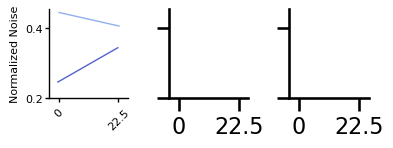

In [106]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale * 2, 2.692 * cm_to_in * scale), sharex=True, sharey=True)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', ]

## get ncell in df_decorr for each area
ncell_area = []
for df_decorr in [df_decorr_V1, ]:
    ncell_area.append(df_decorr.cell_id.nunique())

# for iarea, df in enumerate([df_noise_V1_1trial, df_noise_LM_1trial, df_noise_LI_1trial]):

    # df['noise'] = df.noise.apply(lambda x: x*1e17 if x < 1e-17 else x) # scale up for plotting
    # ax[iarea] = sns.lineplot(data=df, 
    #                          x='stim2_dist', y='noise', hue='isi', 
    #                         errorbar='se', err_style="bars", err_kws={'elinewidth': 1},
    #                         ax=ax[iarea],
    #                         palette=color_list[iarea*2 : iarea*2+1+1], linewidth=1, alpha=0.9)
    
for iarea, cos_sim_boots in enumerate([noise_sess_V1_1trial, ]):
    if np.min(cos_sim_boots) < 1e-17:
        cos_sim_boots *= 1e17
    # cos_sim_boots = cos_sim_boots / np.max(cos_sim_boots, axis=1, keepdims=True) # normalize by max across isi-stim2_dist
    cos_sim_avg = np.mean(cos_sim_boots, axis=0) # across boots
    cos_sim_sem = np.std(cos_sim_boots, axis=0) / np.sqrt(cos_sim_boots.shape[0])
    nori = df_decorr_V1.stim2_dist.nunique()

    ax[iarea].errorbar(x=np.arange(nori) + 0.01, 
                       y=cos_sim_avg[nori:],
                       yerr=cos_sim_sem[nori:],
                       color=color_list_noad[iarea], label=f'{area_list[iarea]} unadapted',
                       linewidth=1, alpha=0.9, )
    
    ax[iarea].errorbar(x=np.arange(nori) - 0.01, 
                       y=cos_sim_avg[:nori],
                       yerr=cos_sim_sem[:nori],
                       color=color_list_250[iarea], label=f'{area_list[iarea]} adapted',
                       linewidth=1, alpha=0.9, )

    # xticks = np.arange(0, 90+1, 22.5)
    xticks = np.arange(0, 2)
    ax[iarea].set_xticks(xticks, ['0', '22.5', ], rotation=45, fontsize=8);
    ylim_lower = np.round(ax[iarea].get_ylim()[0], 1)
    ylim_upper = np.round(ax[iarea].get_ylim()[1], 1)
    # yticks = np.linspace(ylim_lower, ylim_upper, 3)
    yticks = np.arange(ylim_lower, ylim_upper+0.1, 0.2)
    ax[iarea].set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);
    ax[iarea].tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    ax[iarea].tick_params(direction='out', length=3, width=1)

    xlim_lower = ax[iarea].get_xlim()[0]
    xlim_upper = ax[iarea].get_xlim()[1]
    # xlim_pad = 0.5
    xlim_pad = 0.1
    ax[iarea].set_xlim(xlim_lower-xlim_pad, xlim_upper+xlim_pad)
    ax[iarea].spines['left'].set_linewidth(1) # set axis width
    ax[iarea].spines['bottom'].set_linewidth(1)

    # ax[iarea].legend_.remove()
    ax[iarea].set_xlabel('');
    ax[iarea].set_ylabel('');

    

ax[0].set_ylabel('Normalized Noise', fontsize=8);
sns.despine();
fig.tight_layout(); 

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_noise_grat2ori.svg'
fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

### cos simil

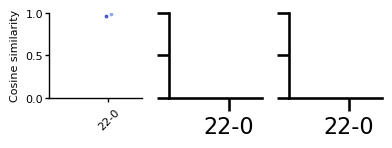

In [110]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale*2, 2.692 * cm_to_in * scale), sharex=True, sharey=True)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', ] # 'LM', 'LI']

# cos_sim_LI_neighbor_sess, _ = sim_sess(df_decorr_LI, ref_ori='neighbor', metric='cos_sim')
# cos_sim_LI_neighbor_sess[:, 1][cos_sim_LI_neighbor_sess[:, 1] < 0] = np.median(cos_sim_LI_neighbor_sess[:, 1][cos_sim_LI_neighbor_sess[:, 1] > 0]) # LI adapted 22-0 exclude an outlier

for iarea, cos_sim_boots in enumerate([cos_sim_V1_neighbor_sess, ]): # cos_sim_LM_neighbor_sess, cos_sim_LI_neighbor_sess]):

    cos_sim_avg = np.mean(cos_sim_boots, axis=0) # across boots
    nori = df_decorr_V1.stim2_dist.nunique()

    scatter_size = 3
    ax[iarea].scatter(np.arange(nori)[1:] + 0.01, 
                       cos_sim_avg[nori+1:],
                    #    yerr=np.std(cos_sim_boots, axis=0)[nori+1:] / np.sqrt(cos_sim_boots.shape[0]),
                       color=color_list_noad[iarea], label=f'{area_list[iarea]} unadapted',
                       linewidth=1, alpha=0.9, s=scatter_size)
    
    ax[iarea].scatter(np.arange(nori)[1:] - 0.01, 
                       cos_sim_avg[1:nori],
                    #    yerr=np.std(cos_sim_boots, axis=0)[1:nori] / np.sqrt(cos_sim_boots.shape[0]),
                       color=color_list_250[iarea], label=f'{area_list[iarea]} adapted',
                       linewidth=1, alpha=0.9, s=scatter_size)


    ax[iarea].set_xticks(range(nori)[1:], ['22-0', ], rotation=45, fontsize=8);
    yticks = np.arange(0, 1.1, 0.5)
    ax[iarea].set_yticks(yticks, [str(i) for i in yticks], fontsize=8);
    ax[iarea].tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    ax[iarea].tick_params(direction='out', length=3, width=1)

    xlim_upper = ax[iarea].get_xlim()[1]
    ax[iarea].set_xlim(1-0.2, xlim_upper+0.1)
    ax[iarea].spines['left'].set_linewidth(1) # set axis width
    ax[iarea].spines['bottom'].set_linewidth(1)
    # ax[iarea].legend(frameon=False, loc='lower right', fontsize=8)

ax[1].set_xlabel('');
ax[0].set_ylabel('Cosine similarity', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_cossim_grat2ori.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

### dot product

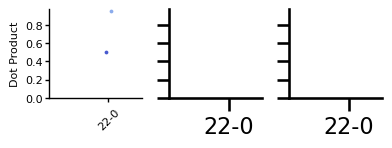

In [109]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale*2, 2.692 * cm_to_in * scale), sharex=True, sharey=True)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', ]

## get ncell in df_decorr for each area
ncell_area = []
for df_decorr in [df_decorr_V1, ]:
    ncell_area.append(df_decorr.cell_id.nunique())

for iarea, cos_sim_boots in enumerate([dot_prod_V1_neighbor_sess, ]):

    ## normalize sim values in sim_boots by ncell, then by max
    cos_sim_boots = cos_sim_boots / ncell_area[iarea]
    cos_sim_boots = cos_sim_boots / np.max(cos_sim_boots)
    cos_sim_avg = np.mean(cos_sim_boots, axis=0) # across boots
    nori = df_decorr_V1.stim2_dist.nunique()


    scatter_size = 3
    ax[iarea].scatter(np.arange(nori)[1:] + 0.01, 
                       cos_sim_avg[nori+1:],
                    #    yerr=np.std(cos_sim_boots, axis=0)[nori+1:] / np.sqrt(cos_sim_boots.shape[0]),
                       color=color_list_noad[iarea], label=f'{area_list[iarea]} unadapted',
                       linewidth=1, alpha=0.9, s=scatter_size)
    
    ax[iarea].scatter(np.arange(nori)[1:] - 0.01, 
                       cos_sim_avg[1:nori],
                    #    yerr=np.std(cos_sim_boots, axis=0)[1:nori] / np.sqrt(cos_sim_boots.shape[0]),
                       color=color_list_250[iarea], label=f'{area_list[iarea]} adapted',
                       linewidth=1, alpha=0.9, s=scatter_size)


    ax[iarea].set_xticks(range(nori)[1:], ['22-0', ], rotation=45, fontsize=8);
    ylim_upper = ax[iarea].get_ylim()[1]
    # yticks = np.linspace(ylim_lower, ylim_upper, 3)
    yticks = np.arange(0, ylim_upper, 0.2)
    ax[iarea].set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);
    ax[iarea].tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    ax[iarea].tick_params(direction='out', length=3, width=1)

    xlim_upper = ax[iarea].get_xlim()[1]
    ax[iarea].set_xlim(1-0.2, xlim_upper+0.1)
    ax[iarea].spines['left'].set_linewidth(1) # set axis width
    ax[iarea].spines['bottom'].set_linewidth(1)
    # ax[iarea].legend(frameon=False, loc='upper right', fontsize=8)

ax[1].set_xlabel('');
ax[0].set_ylabel('Dot Product', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_dotprod_grat2ori.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')